# Prediction of the winning player in a tennis match

Author: Ahlem JOUIDI

The aim of this work is to explore data from ATP tennis competitions in order to predict the results of tennis matches.

## Import librairies

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import random
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelBinarizer

from sklearn.model_selection import train_test_split
from sklearn import utils
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from xgboost import XGBClassifier

import shap

# Load the data

In [2]:
# Load the data in format of Pandas DataFrame
df = pd.read_csv("/kaggle/input/atpdata/ATP.csv")
df.shape

(169690, 49)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169690 entries, 0 to 169689
Data columns (total 49 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   best_of             169690 non-null  int64  
 1   draw_size           1232 non-null    float64
 2   l_1stIn             83415 non-null   float64
 3   l_1stWon            83415 non-null   float64
 4   l_2ndWon            83415 non-null   float64
 5   l_SvGms             83415 non-null   float64
 6   l_ace               83415 non-null   float64
 7   l_bpFaced           83415 non-null   float64
 8   l_bpSaved           83415 non-null   float64
 9   l_df                83415 non-null   float64
 10  l_svpt              83415 non-null   float64
 11  loser_age           164700 non-null  float64
 12  loser_entry         25339 non-null   object 
 13  loser_hand          169605 non-null  object 
 14  loser_ht            139052 non-null  float64
 15  loser_id            169690 non-nul

In [4]:
df.head()

,best_of,draw_size,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_ace,l_bpFaced,l_bpSaved,l_df,...,winner_age,winner_entry,winner_hand,winner_ht,winner_id,winner_ioc,winner_name,winner_rank,winner_rank_points,winner_seed
0,5,64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,R,NaN,110023,AUS,Richard Coulthard,NaN,NaN,NaN
1,5,64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27.520876,NaN,R,NaN,109803,AUS,John Brown,NaN,NaN,NaN
2,5,64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.216290,NaN,R,NaN,100257,AUS,Ross Case,NaN,NaN,NaN
3,5,64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,22.264203,NaN,R,NaN,100105,AUS,Allan Stone,NaN,NaN,5.0
4,5,64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,29.861739,NaN,R,NaN,109966,AUS,Warren Jacques,NaN,NaN,NaN


In [5]:
df.columns

Index(['best_of', 'draw_size', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms',
       'l_ace', 'l_bpFaced', 'l_bpSaved', 'l_df', 'l_svpt', 'loser_age',
       'loser_entry', 'loser_hand', 'loser_ht', 'loser_id', 'loser_ioc',
       'loser_name', 'loser_rank', 'loser_rank_points', 'loser_seed',
       'match_num', 'minutes', 'round', 'score', 'surface', 'tourney_date',
       'tourney_id', 'tourney_level', 'tourney_name', 'w_1stIn', 'w_1stWon',
       'w_2ndWon', 'w_SvGms', 'w_ace', 'w_bpFaced', 'w_bpSaved', 'w_df',
       'w_svpt', 'winner_age', 'winner_entry', 'winner_hand', 'winner_ht',
       'winner_id', 'winner_ioc', 'winner_name', 'winner_rank',
       'winner_rank_points', 'winner_seed'],
      dtype='object')

# Exploratory Data Analysis

The objective of this analysis is to come up with insights regarding the tournaments using different types of visualizations as tools to facilitate interpretation of the data and variables and communication of the results.

Let's start with histograms to better understand the distribution of the key variables of our dataset based on multiple dimensions.

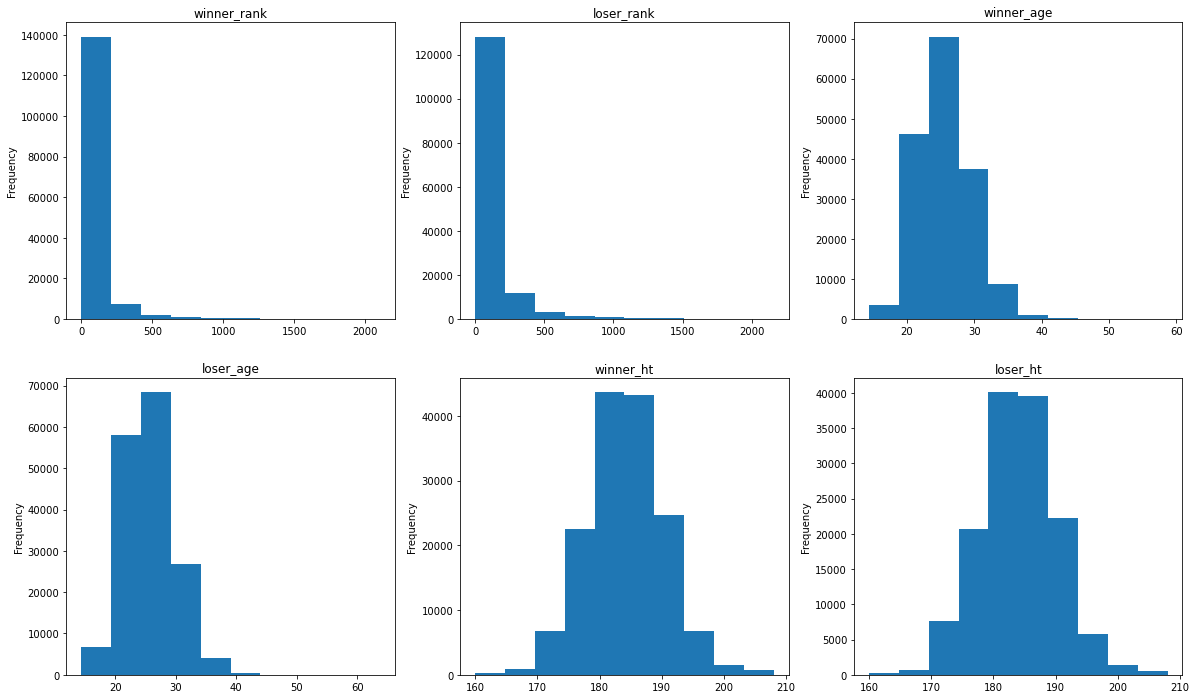

In [6]:
dimensions = ['winner_rank','loser_rank','winner_age','loser_age','winner_ht','loser_ht']

plt.figure(1, figsize=(20,12))

for i in range(1,7):
    plt.subplot(2,3,i)
    df[dimensions[i-1]].plot(kind='hist', title=dimensions[i-1])

Text(0.5, 1.0, '10 Top players')

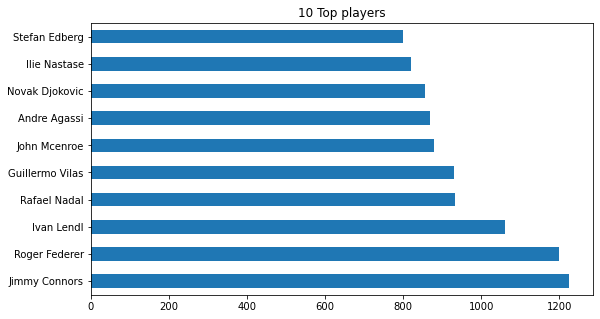

In [7]:
plt.figure(figsize=(9,5))
df['winner_name'].value_counts()[:10].plot(kind='barh')
plt.title('10 Top players')

The players who won the most matches are the likely to win again.

Let's now plot the correclation matrix and try to explore relations between features.

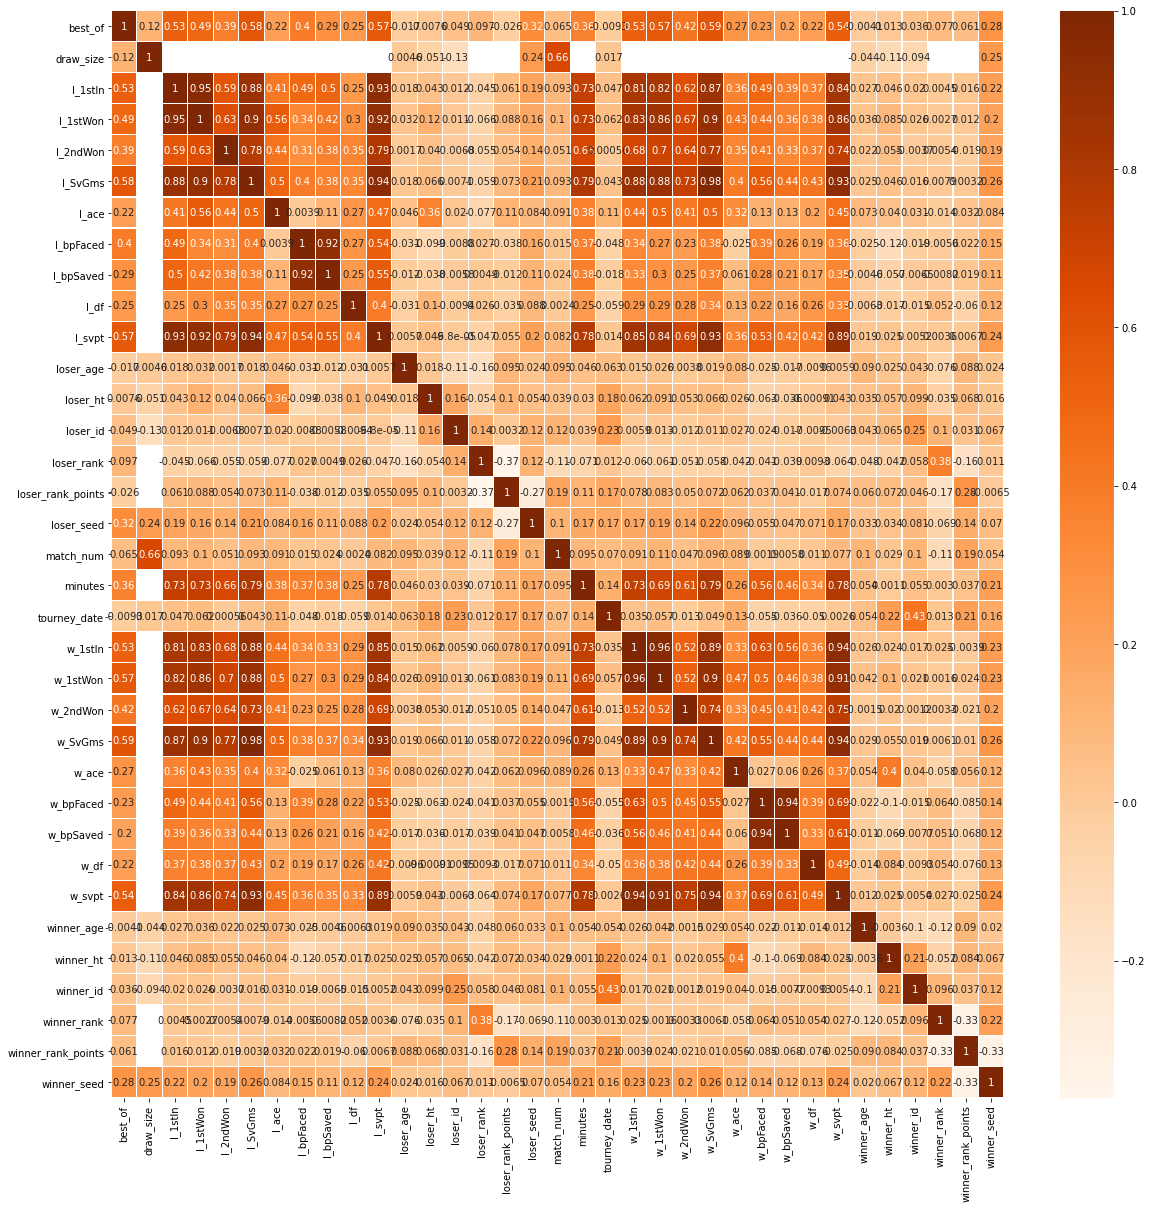

In [8]:
correlation_matrix = df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, annot= True, linewidth=0.1, cmap= 'Oranges')

* We can see clearly that "minutes", "score", "1stIn", "_1stWon" ,"SvGms", "l_bpFaced", "l_bpSaved" and "svpt" features are highly correlated to each other. This is expected because they represent the result of a match.
* Features like rank, rank_points, age and ht are important ones.

# Preporcessing 

As first step, let's clean the data and retain only important features for our prediction task.

We proceed to the removal of features that are redundant/ crrelated with each other, and those that are obviously not available before a match to predict. 
* "winner_name", "loser_name" & "tourney_name" because they are almost redundant and replaceable by respectively "winner_id", "loser_id" & "tourney_id". 

* "minutes", "score", "1stIn", "_1stWon" ,"SvGms", "l_bpFaced", "l_bpSaved", "svpt" features because cannot be known in advance.

In [9]:
df = df.drop(columns=['score','tourney_name','winner_name',
                      'loser_name','minutes', 'l_1stIn', 'l_1stWon', 'l_2ndWon','l_ace', 'l_svpt',
                      'l_SvGms','l_bpFaced','l_df', 'l_bpSaved',  'w_1stIn', 'w_1stWon','w_2ndWon', 'w_SvGms',
                      'w_ace', 'w_svpt','w_bpFaced', 'w_bpSaved','w_df'])
print("remained features ", df.columns)

remained features  Index(['best_of', 'draw_size', 'loser_age', 'loser_entry', 'loser_hand',
       'loser_ht', 'loser_id', 'loser_ioc', 'loser_rank', 'loser_rank_points',
       'loser_seed', 'match_num', 'round', 'surface', 'tourney_date',
       'tourney_id', 'tourney_level', 'winner_age', 'winner_entry',
       'winner_hand', 'winner_ht', 'winner_id', 'winner_ioc', 'winner_rank',
       'winner_rank_points', 'winner_seed'],
      dtype='object')


Let's now count the number and the percentage of None values in our data set and treat features and entries that contain a lot of them.

In [10]:
none_percent = df.isnull().sum() * 100 / len(df)
none_values_df = pd.DataFrame({'Feature name': df.columns, 'None values count': df.isnull().sum(),
                                 'None values percent': none_percent})
print(none_values_df.reset_index().drop(columns=['index']))

          Feature name  None values count  None values percent
0              best_of                  0             0.000000
1            draw_size             168458            99.273970
2            loser_age               4990             2.940656
3          loser_entry             144351            85.067476
4           loser_hand                 85             0.050091
5             loser_ht              30638            18.055277
6             loser_id                  0             0.000000
7            loser_ioc                  0             0.000000
8           loser_rank              23781            14.014379
9    loser_rank_points              76665            45.179445
10          loser_seed             136837            80.639401
11           match_num                  0             0.000000
12               round                  0             0.000000
13             surface               2539             1.496258
14        tourney_date                  0             0

We can see that we have a lot of null values, so we have to handle them.

We will remove feature that have more than 85% of None values.

In [11]:
features_to_remove = none_values_df[none_values_df["None values percent"] > 85]
print(features_to_remove)
df = df.drop(columns=features_to_remove['Feature name'].values)

              Feature name  None values count  None values percent
draw_size        draw_size             168458            99.273970
loser_entry    loser_entry             144351            85.067476
winner_entry  winner_entry             154942            91.308857


Since "rank_points" and "rank", which contain past performance of players, and "surface" features are important ones, we will delete the entries that do not contain information about them.

In [12]:
df.dropna(subset=['winner_rank_points', 'loser_rank_points','winner_rank','loser_rank', 'surface'], inplace=True)
df = df.reset_index(drop=True)
df

,best_of,loser_age,loser_hand,loser_ht,loser_id,loser_ioc,loser_rank,loser_rank_points,loser_seed,match_num,...,tourney_id,tourney_level,winner_age,winner_hand,winner_ht,winner_id,winner_ioc,winner_rank,winner_rank_points,winner_seed
0,3,20.40,R,190.0,101632,SWE,282.0,70.0,NaN,1,...,1990-339,A,18.96,R,188.0,101843,ESP,25.0,591.0,1.0
1,3,25.01,L,190.0,101096,RSA,127.0,182.0,NaN,2,...,1990-339,A,29.00,L,183.0,100714,AUS,146.0,157.0,NaN
2,3,23.90,R,183.0,101232,SWE,71.0,290.0,NaN,3,...,1990-339,A,21.20,R,193.0,101529,GER,113.0,215.0,NaN
3,3,21.94,L,190.0,101434,CZE,80.0,271.0,NaN,4,...,1990-339,A,30.23,R,201.0,100628,NED,68.0,297.0,7.0
4,3,22.35,R,180.0,101387,ITA,100.0,224.0,NaN,5,...,1990-339,A,22.25,L,180.0,101404,AUT,34.0,496.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92452,3,31.78,R,188.0,104919,ARG,55.0,895.0,4.0,296,...,2019-0533,A,22.74,R,NaN,106426,CHI,92.0,620.0,NaN
92453,3,25.69,R,NaN,106198,BOL,95.0,600.0,NaN,297,...,2019-0533,A,20.18,R,NaN,134770,NOR,108.0,527.0,NaN
92454,3,23.73,R,NaN,111513,SRB,37.0,1127.0,NaN,298,...,2019-0533,A,28.78,L,185.0,105550,ARG,48.0,975.0,3.0
92455,3,20.18,R,NaN,134770,NOR,108.0,527.0,NaN,299,...,2019-0533,A,22.74,R,NaN,106426,CHI,92.0,620.0,NaN


To avoid analytical errors, we will convert numerical values of string format to float type.

In [13]:
numeric_columns = ['winner_rank', 'loser_rank', 'winner_age', 'loser_age', 'winner_ht', 'loser_ht']
df[numeric_columns] = df[numeric_columns].astype(float)

In [14]:
df.tourney_date

0        19900101
1        19900101
2        19900101
3        19900101
4        19900101
           ...   
92452    20190225
92453    20190225
92454    20190225
92455    20190225
92456    20190225
Name: tourney_date, Length: 92457, dtype: int64

We will expand the "tourney_date" feature to new columns storing year and month attributes.

In [15]:
#"tourney_date" is in the format of YYYYMMDD
df['tourney_year'] = df.tourney_date.astype(str).str[:4].astype(int)
df['tourney_month'] = df.tourney_date.astype(str).str[4:6].astype(int)
#Now drop "tourney_date"
df = df.drop(columns=['tourney_date'])

# Feature engineering

For our supervised prediction model, we have to define our target feature!

We will transform our data so that we  have 2 players (first player & second player), their respective personal informations (id, hand, age, etc) and general informations about the match and the tourney.

Then we will create a column "label" which is equal to 1 if player 1 wins, 0 if player 2 wins.

to do so, we will create a first copy of our dataset where the winner is considered as first player so **label=0**. Then a second copy where we inverse the places of the players so **label=1**.


First copy of the data where the loser is considered as first player and the winner as second player

In [16]:
df = df.rename(columns={"loser_age": "first_age", "loser_entry": "first_entry", "loser_hand": "first_hand",
                        "loser_ht": "first_ht", "loser_id": "first_id", "loser_ioc": "first_ioc",
                        "loser_rank": "first_rank", "loser_rank_points": "first_rank_points",
                        "loser_seed": "first_seed",
                
                        "winner_age": "second_age", "winner_entry": "second_entry","winner_hand": "second_hand",
                        "winner_ht": "second_ht", "winner_id": "second_id", "winner_ioc": "second_ioc",
                        "winner_rank": "second_rank", "winner_rank_points": "second_rank_points",
                        "winner_seed": "second_seed",
                       },)

Create second copy with inverse of positions

In [17]:
copy_2_df = df.copy()
copy_2_df[[ 'first_age','first_hand','first_ht','first_id','first_ioc','first_rank','first_rank_points','first_seed',
            'second_age','second_hand','second_ht','second_id','second_ioc','second_rank','second_rank_points','second_seed']]\
=copy_2_df[['second_age','second_hand','second_ht','second_id','second_ioc','second_rank','second_rank_points','second_seed',
             'first_age','first_hand','first_ht','first_id','first_ioc','first_rank','first_rank_points','first_seed']]


Construct label feature

In [18]:
winner_player2 = np.zeros(df.shape[0]) # second player wins so label=0
df['label'] = winner_player2


winner_player1 = np.ones(copy_2_df.shape[0]) # first player wins so label=1
copy_2_df['label'] = winner_player1 

df = pd.concat([df,copy_2_df])
#shuffle data
df = df.sample(frac=1).reset_index(drop=True)
df

,best_of,first_age,first_hand,first_ht,first_id,first_ioc,first_rank,first_rank_points,first_seed,match_num,...,second_hand,second_ht,second_id,second_ioc,second_rank,second_rank_points,second_seed,tourney_year,tourney_month,label
0,5,23.73,R,185.0,104214,RUS,235.0,170.0,NaN,4,...,R,175.0,103206,FRA,59.0,620.0,NaN,2007,4,0.0
1,3,25.06,R,188.0,104714,GER,94.0,539.0,NaN,10,...,R,196.0,104978,GER,106.0,511.0,NaN,2011,4,1.0
2,5,24.25,R,183.0,104571,CYP,103.0,575.0,NaN,2,...,R,NaN,105573,FIN,620.0,47.0,NaN,2009,9,1.0
3,3,27.78,R,185.0,103484,USA,7.0,2235.0,1.0,1,...,R,183.0,102035,SWE,57.0,615.0,NaN,2007,10,1.0
4,3,21.66,R,190.0,102856,BRA,9.0,2364.0,8.0,25,...,R,183.0,101475,ESP,56.0,808.0,NaN,1998,5,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184909,5,27.86,R,175.0,101195,ISR,28.0,1097.0,NaN,107,...,L,188.0,101334,RUS,15.0,1420.0,14.0,1993,8,0.0
184910,3,22.06,R,193.0,105217,NED,47.0,980.0,NaN,27,...,R,185.0,104338,ARG,41.0,1085.0,NaN,2010,10,0.0
184911,3,25.68,L,180.0,101404,AUT,15.0,1576.0,1.0,31,...,R,188.0,102146,ESP,107.0,401.0,NaN,1993,6,1.0
184912,5,23.29,R,188.0,103709,DEN,846.0,11.0,NaN,15,...,L,185.0,104268,COL,146.0,276.0,NaN,2004,5,0.0


The problem with this method is that we have duplicated the dataset to be able to consider the two players in the two positions. 

I tried another method where the idea was **to assign randomly** the winner and loser players to the first and second players features and if :
* winner player is assigned to player_1 and loser to player_2 then label=0
* winner player is assigned to player_2 and loser to player_1 then label=1

This method preserve the original size of data and enable as to create the label target. However after further work and execution of the classifiers we got overfitting problem. So we will keep the first method.

Below is the source code of this method.

In [19]:
# first_player = []
# second_player = []
# labels = []
# for winner, looser in zip(df['winner_id'], df['loser_id']):
#     number = np.random.choice([0,1],1)[0] #the number of the winner
#     if number == 0: #the winner is player 0 and the loser is player 1 => label = 0
#         first_player.append(winner)
#         second_player.append(looser)
        
#     else: #the loser is player 0 and the winner is player 1 => label = 1
#         second_player.append(winner)
#         first_player.append(looser)
    
#     labels.append(number)
# df['first_player_id'] = first_player
# df['second_player_id'] = second_player
# df['label'] = labels
# df = df.drop(columns=['loser_id', 'winner_id'])

For our prediction model, we have to encode categorical features. We will use LaberEncoder of Sklearn library.

In [20]:
hand_encoder = LabelEncoder()
df['first_hand'] = hand_encoder.fit_transform(df['first_hand'].astype(str))
df['second_hand'] = hand_encoder.transform(df['second_hand'].astype(str))

df['first_ioc'] = LabelEncoder().fit_transform(df['first_ioc'].astype(str))
df['second_ioc'] = LabelEncoder().fit_transform(df['second_ioc'].astype(str))

df['surface'] = LabelBinarizer().fit_transform(df['surface'].astype(str))
df['tourney_level'] = LabelEncoder().fit_transform(df['tourney_level'].astype(str))
df['tourney_id'] = LabelEncoder().fit_transform(df['tourney_id'].astype(str))
df['round'] = LabelEncoder().fit_transform(df['round'].astype(str))

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184914 entries, 0 to 184913
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   best_of             184914 non-null  int64  
 1   first_age           184781 non-null  float64
 2   first_hand          184914 non-null  int64  
 3   first_ht            174647 non-null  float64
 4   first_id            184914 non-null  int64  
 5   first_ioc           184914 non-null  int64  
 6   first_rank          184914 non-null  float64
 7   first_rank_points   184914 non-null  float64
 8   first_seed          59187 non-null   float64
 9   match_num           184914 non-null  int64  
 10  round               184914 non-null  int64  
 11  surface             184914 non-null  int64  
 12  tourney_id          184914 non-null  int64  
 13  tourney_level       184914 non-null  int64  
 14  second_age          184781 non-null  float64
 15  second_hand         184914 non-nul

Finally, let's handle the few remaing None values using SimpleImputer.

In [21]:
df_imputed = pd.DataFrame(SimpleImputer().fit_transform(df))
df_imputed.columns = df.columns
df_imputed.index = df.index
df = df_imputed.copy()

In [22]:
print('Final shape of data after cleaning and preprocessing: ', df.shape)

Final shape of data after cleaning and preprocessing:  (184914, 25)


# Prediction model

Let's now train and execute our prediction model. For this we will use 2 differents models : RandomForest and XGBoost.

In [23]:
y = df['label']
df_X = df.drop(columns='label')

In [24]:
# split data : 80% for train and 20% for test.
X_train, X_test, y_train, y_test = train_test_split(df_X, y, test_size=0.2)

### RandomForest classifier

Random Forests or random decision forests are an ensemble learning method for classification, regression and other tasks that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes of the individual trees.


In [25]:
#Call the classifier
RF_classifier = RandomForestClassifier(n_estimators=100)
#fit the data
RF_classifier.fit(X_train, y_train)
#predict 
RF_predictions = RF_classifier.predict(X_test)

In [26]:
print('Confusion matrix')
print(confusion_matrix(y_test,RF_predictions))
print('Classification report')
print(classification_report(y_test,RF_predictions))
print('Accuracy= ', accuracy_score(y_test, RF_predictions))

Confusion matrix
[[12261  6277]
 [ 6744 11701]]
Classification report
              precision    recall  f1-score   support

         0.0       0.65      0.66      0.65     18538
         1.0       0.65      0.63      0.64     18445

    accuracy                           0.65     36983
   macro avg       0.65      0.65      0.65     36983
weighted avg       0.65      0.65      0.65     36983

Accuracy=  0.6479193142795339


### XGBoost classifier

Like Random Forests,  Extreme Gradient Boosting is a set of decision trees. The two main differences are:

**How trees are built:** random forests builds each tree independently while gradient boosting builds one tree at a time. This additive model (ensemble) works in a forward stage-wise manner, introducing a weak learner to improve the shortcomings of existing weak learners. 
**Combining results:** random forests combine results at the end of the process (by averaging or "majority rules") while gradient boosting combines results along the way.

In [27]:
#Call the classifier
XGB_classifier = XGBClassifier()
#fit the data
XGB_classifier.fit(X_train, y_train)
#predict 
XGB_predictions = XGB_classifier.predict(X_test)

In [28]:
print('Confusion matrix')
print(confusion_matrix(y_test,XGB_predictions))
print('Classification report')
print(classification_report(y_test,XGB_predictions))
print('Accuracy= ', accuracy_score(y_test, XGB_predictions))

Confusion matrix
[[12270  6268]
 [ 6364 12081]]
Classification report
              precision    recall  f1-score   support

         0.0       0.66      0.66      0.66     18538
         1.0       0.66      0.65      0.66     18445

    accuracy                           0.66     36983
   macro avg       0.66      0.66      0.66     36983
weighted avg       0.66      0.66      0.66     36983

Accuracy=  0.6584376605467377


XGBoost gives slightly better results than RandomForest.

## Feature importance 

We will use SHAP (SHapley Additive exPlanations) library which is a game theoretic approach to explain the output of any machine learning model. It will allow as visualize the behaviour of the classifer as well as the most important features used.

We will visualize the output of XGBoost model.

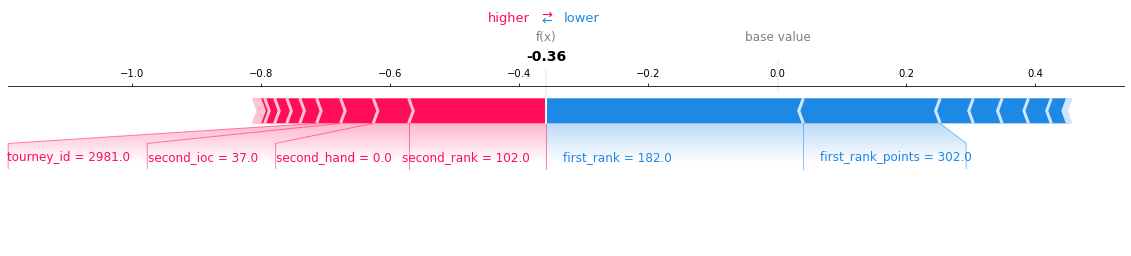

In [29]:
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(XGB_classifier)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:], matplotlib=True)

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

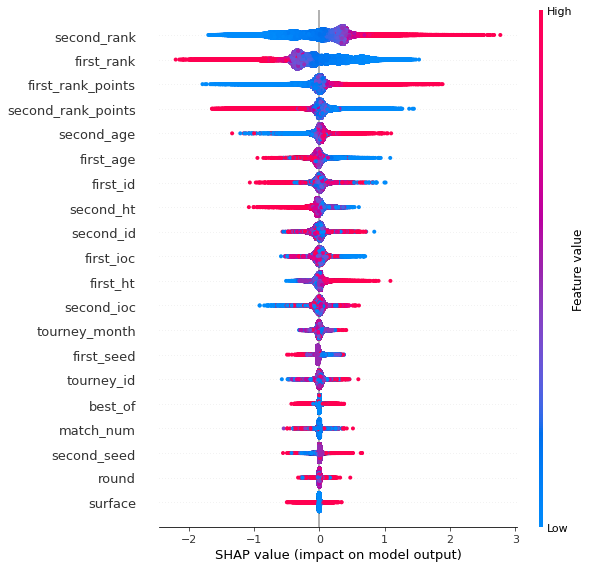

In [30]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

This plot allow as to get an overview of which features are most important for a model. "First_rank", "second_rank", "first_rank_points" and "second_rank_points" are the most important features. This is expected as those features express directly the level of performance of each player. 

The color represents the feature value (red high, blue low). This reveals for example that a high first_rank (rank of first player) lowers the predicted labels (label tends vers 0).

# Further work

With more time we can:
* Make more in-depth cleaning of the data and more accurate feature engineering.
* Fine tune the hyperparameters of the classifiers in order to improve the quality of prediction.
*  Use Time Series to  better exploit the time features.
*  We could suggest making predictions during the match by including information about the current situation (number of minutes spent, number of faults, ect.).

Time needed to finish this test: about 6 hours.